# Add Folders to Path

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add EllipticOECS folder to current working path in order to access the functions
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/FastTensorlineComputation")

CPU times: user 148 µs, sys: 134 µs, total: 282 µs
Wall time: 231 µs


In [2]:
# Suppress numba warnings arising from computation falling back into object mode.
from numba.core.errors import NumbaDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)

# Import data

In [3]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/ABC/ABC_steady.mat')

U = mat_file['u']
V = mat_file['v']
W = mat_file['w']
x = mat_file['x']
y = mat_file['y']
z = mat_file['z']

CPU times: user 57 ms, sys: 68.1 ms, total: 125 ms
Wall time: 124 ms


# Data/Parameters for Dynamical System

In [4]:
import numpy as np

# number of cores to be used for parallel computing
Ncores = 18

# periodic boundary conditions
periodic_x = True
periodic_y = True
periodic_z = True
periodic = [periodic_x, periodic_y, periodic_z]

# unsteady velocity field
bool_unsteady = False

## compute meshgrid of dataset
X, Y, Z = np.meshgrid(x, y, z)

## resolution of meshgrid
dx_data = X[0,1,0]-X[0,0,0]
dy_data = Y[1,0,0]-Y[0,0,0]
dz_data = Z[0,0,1]-Z[0,0,0]

delta = [dx_data, dy_data, dz_data]

# Spatio-Temporal Domain of Dynamical System

In [5]:
%%time
from math import pi

# Time
t0 = 0
tN = 10
dt = 0.1

# store time in array
time = np.arange(t0, tN+dt, dt)

lenT = 10

# domain boundary (in degrees)
xmin = 0
xmax = 2*pi
ymin = 0
ymax = 2*pi
zmin = 0
zmax = 2*pi

# spacing of meshgrid (in degrees)
dx = 0.05
dy = 0.05
dz = 0.05

x_domain = np.linspace(xmin, xmax, int((xmax-xmin)/dx), endpoint = True)
y_domain = np.linspace(ymin, ymax, int((ymax-ymin)/dy), endpoint = True)
z_domain = np.linspace(ymin, ymax, int((zmax-zmin)/dz), endpoint = True)

X_domain, Y_domain, Z_domain = np.meshgrid(x_domain, y_domain, z_domain)

CPU times: user 8.41 ms, sys: 8.7 ms, total: 17.1 ms
Wall time: 16.2 ms


# Interpolate Velocity

In order to evaluate the velocity field at arbitrary locations and times, we must interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". In order to favour a smooth velocity field, we interpolate the velocity field in space using a cubic interpolant. 

In [6]:
%%time
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_steady

# Interpolate velocity data using linear spatial interpolation
Interpolant = interpolant_steady(X, Y, Z, U, V, W)

CPU times: user 34.6 ms, sys: 16.2 ms, total: 50.9 ms
Wall time: 50 ms


# Rate of Strain $ \mathrm{S}(\mathbf{x})$

In [7]:
%%time
# Import package to compute gradient of velocity
from ipynb.fs.defs.gradient_velocity import gradient_velocity

# Import package to compute rate of strain
from ipynb.fs.defs.RateStrain import RateStrain

# Import package for progress bar
from tqdm.notebook import tqdm

# Import package for parallel computing
from joblib import Parallel, delayed

# Define auxiliary grid 
aux_grid = [np.around(.1*dx, 5), np.around(.1*dy, 5), np.around(.1*dz, 5)]

def parallel_S(i):
    
    S_parallel = np.zeros((X_domain.shape[1], X_domain.shape[2], 3, 3))*np.nan
    
    for j in range(X_domain.shape[1]):
        
        for k in range(Y_domain.shape[2]):
        
            # set initial condition
            x = np.array([X_domain[i, j, k], Y_domain[i, j, k], Z_domain[i, j, k]])
    
            # compute gradient of velocity
            grad_vel = gradient_velocity(time, x, X, Y, Z, Interpolant, periodic, bool_unsteady, aux_grid)
        
            # compute rate of strain
            S_parallel[j,k,:,:] = RateStrain(grad_vel)
        
    return S_parallel

S = np.array(Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_S)(i) for i in tqdm(range(X_domain.shape[0]))))

  0%|          | 0/125 [00:00<?, ?it/s]

CPU times: user 1 s, sys: 472 ms, total: 1.47 s
Wall time: 13min 35s


# Compute Tensorfield properties

We now compute the properties of the rate of strain tensor 'S' such as the spatial derivatives of the elements of 'S'.

In [8]:
%%time
# Import (cubic) RectangularGridInterpolat from scipy
from scipy.interpolate import RegularGridInterpolator
        
# Compute gradients of elements of rate of strain tensor
S11 = np.nan_to_num(S[:,:,:,0,0], nan=0.0)
S12 = np.nan_to_num(S[:,:,:,0,1], nan=0.0)
S22 = np.nan_to_num(S[:,:,:,1,1], nan=0.0)
S33 = np.nan_to_num(S[:,:,:,2,2], nan=0.0)
S23 = np.nan_to_num(S[:,:,:,1,2], nan=0.0)
S13 = np.nan_to_num(S[:,:,:,0,2], nan=0.0)

# Interpolate elements of rate of strain tensor (per default: cubic)
interpS11 = RegularGridInterpolator((Y_domain[:,0,0], X_domain[0,:,0], Z_domain[0,0,:]), S11)
interpS12 = RegularGridInterpolator((Y_domain[:,0,0], X_domain[0,:,0], Z_domain[0,0,:]), S12)
interpS22 = RegularGridInterpolator((Y_domain[:,0,0], X_domain[0,:,0], Z_domain[0,0,:]), S22)
interpS33 = RegularGridInterpolator((Y_domain[:,0,0], X_domain[0,:,0], Z_domain[0,0,:]), S33)
interpS23 = RegularGridInterpolator((Y_domain[:,0,0], X_domain[0,:,0], Z_domain[0,0,:]), S23)
interpS13 = RegularGridInterpolator((Y_domain[:,0,0], X_domain[0,:,0], Z_domain[0,0,:]), S13)

CPU times: user 126 ms, sys: 16.9 ms, total: 143 ms
Wall time: 141 ms


In [11]:
%%time
# import math tools
from math import atan, acos, asin, cos, sin, sqrt

# Import package to compute tensorline equation using ODE solver
from ipynb.fs.defs.tensorline_equation import _tensorline_equation

# Import package to compute tensorlines by re-orienting the vectorfield on the fly
from ipynb.fs.defs.RK4_tensorlines import _RK4_tensorlines

# Import package to solve ODE
from scipy.integrate import solve_ivp

# Import package for parallel computing
from joblib import Parallel, delayed

# import plotting library
import matplotlib.pyplot as plt

# define integration interval of dummy variable 's'
t = [0, 10]
t_eval = np.linspace(t[0], t[-1], 10000)

# initial alignment of eigenvector
init_orientation = np.array([0, 0, 1])

# Import package to compute eigenvalues of 3x3 matrix
from ipynb.fs.defs.eigen import eigen

# define eigenvector_field 
# {0: eigenvector field of maximum eigenvalue}
# {1: eigenvector field of middle eigenvalue}
# {2: eigenvector field of minimum eigenvalue}
idx_eigenvector = 1

counter = 0
x_0 = X_domain[::5,::5,0].ravel()
y_0 = Y_domain[::5,::5,0].ravel()
z_0 = 0

def terminate_ODE(t, x_phi, interpS11, interpS12, interpS13, interpS22, interpS23, interpS33, aux_grid, idx_eigenvector):
                
    x = x_phi[0]%(2*pi)
    y = x_phi[1]%(2*pi)
    z = x_phi[2]%(2*pi)
    
    # compute gradient of velocity
    grad_vel = gradient_velocity(0, np.array([x, y, z]), X, Y, Z, Interpolant, periodic, bool_unsteady, aux_grid)
    
    # compute rate of strain
    S = RateStrain(grad_vel)
    
    # compute eigenvalues/eigenvectors of rate of strain
    lam = eigen(S)[0]
            
    event = abs(lam[0]-lam[1]) <= .01 or abs(lam[0]-lam[2]) <= .01 or abs(lam[1]-lam[2]) <= .01
                
    return 1-event
            
terminate_ODE.terminal = True

def compute_e2(i):
            
    # initial position of particle
    xinit = np.array([x_0[i], y_0[i], z_0])
            
    # compute gradient of velocity
    grad_vel = gradient_velocity(t[0], xinit, X, Y, Z, Interpolant, periodic, bool_unsteady, aux_grid)
        
    # compute rate of strain
    S = RateStrain(grad_vel)
            
    # compute inital eigenvector orientation
    lamda, eigenv = eigen(S)
    initial_vector = eigenv[:,idx_eigenvector]
    if np.sign(init_orientation@initial_vector) < 0:
        initial_vector = -initial_vector
            
    if initial_vector[0] < 0 or (initial_vector[0] < 0 and initial_vector[1] < 0):
        phi0 = atan(initial_vector[1]/initial_vector[0])+pi
    else:
        phi0 = atan(initial_vector[1]/initial_vector[0])
    theta0 = acos(initial_vector[2])
    
    x0 = np.array([x_0[i], y_0[i], z_0, phi0, theta0])
            
    # solve ODE for tensorlines maximum eigenvector field of rate of strain
    solODE = solve_ivp(_tensorline_equation, t, x0, 'RK45', t_eval, rtol=1e-5, atol=1e-5, args=(interpS11, interpS12, interpS13, interpS22, interpS23, interpS33, aux_grid, idx_eigenvector))
    
    return solODE

solODE = Parallel(n_jobs=Ncores, verbose = 0)(delayed(compute_e2)(i) for i in tqdm(range(len(x_0))))


  0%|          | 0/625 [00:00<?, ?it/s]

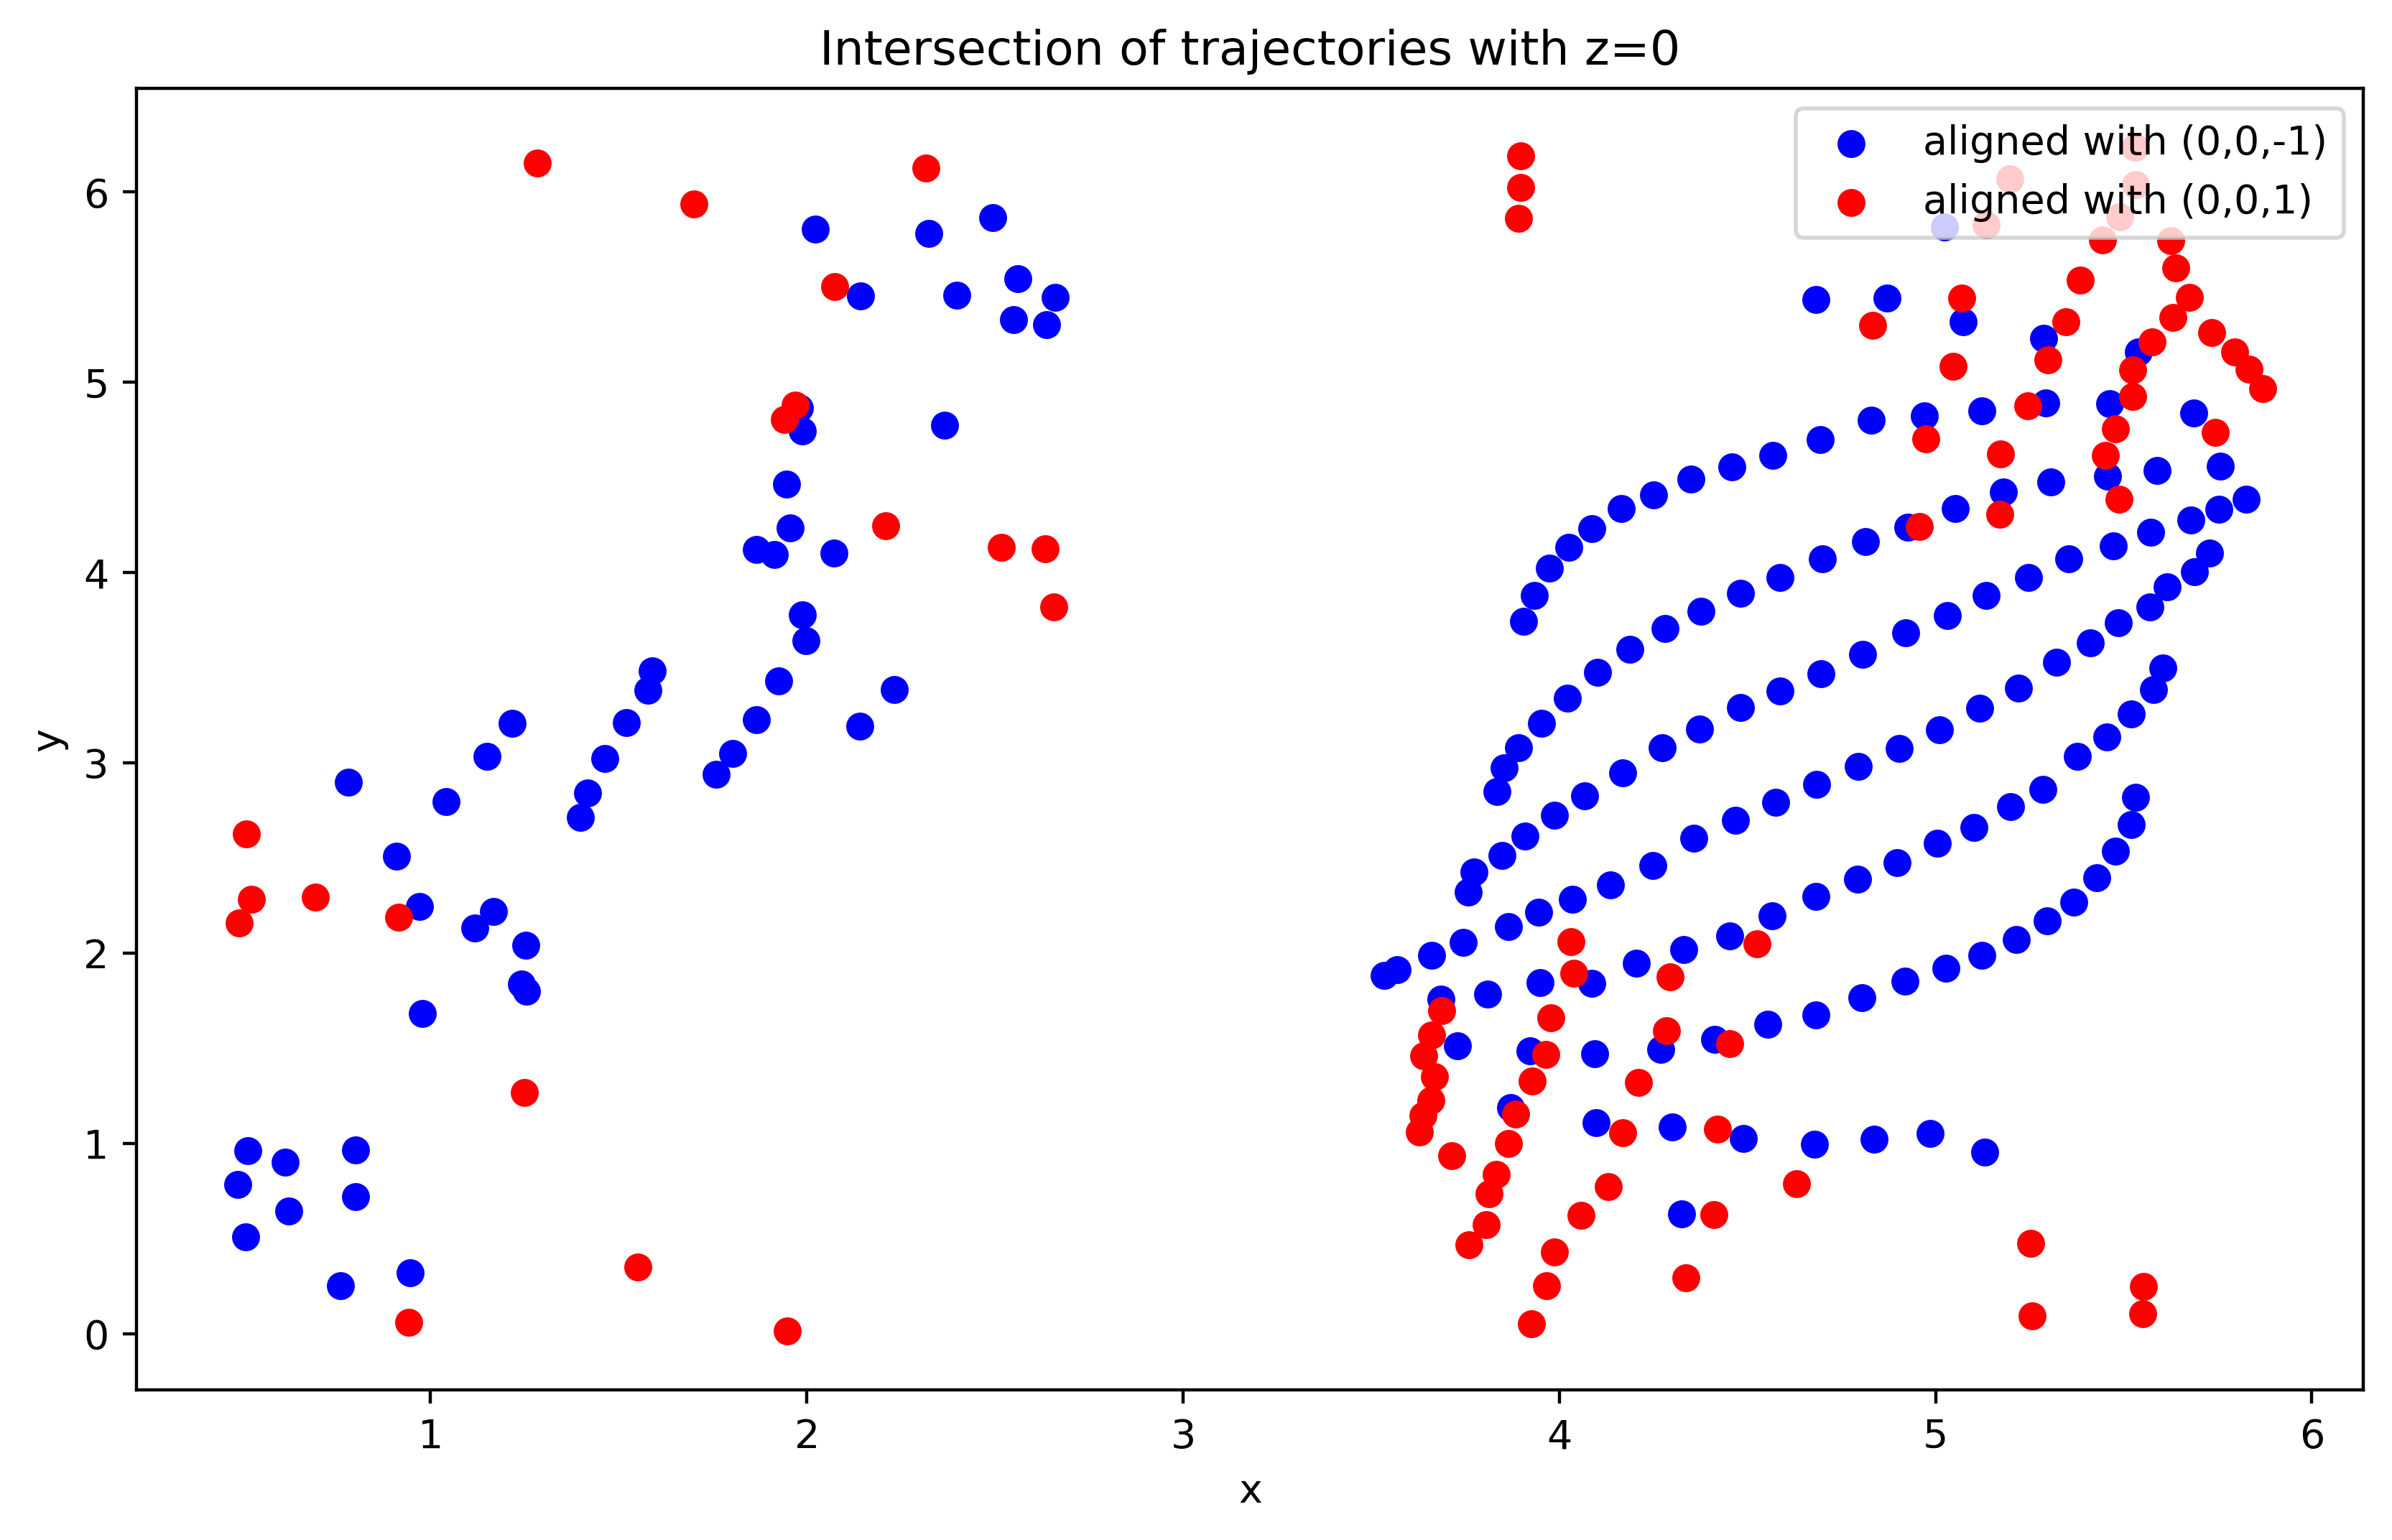

In [21]:
x_intersec_pos, y_intersec_pos, x_intersec_neg, y_intersec_neg = [], [], [], []
for sol in solODE:
    x = sol.y[0,:]%(2*pi)
    y = sol.y[1,:]%(2*pi)
    z = sol.y[2,:]%(2*pi)
    phi = sol.y[3,:]%(2*pi)
    theta = sol.y[4,:]%(pi)
    #ax.scatter(x[0], y[0], marker = "^", edgecolor = "k", facecolor = "k")
    for j in range(len(x)-1):
        if z[j+1] - z[j] > 1:
            x_intersec_pos.append((x[j]+x[j+1])/2)
            y_intersec_pos.append((y[j]+y[j+1])/2)
        elif z[j+1] - z[j] < -1:
            x_intersec_neg.append((x[j]+x[j+1])/2)
            y_intersec_neg.append((y[j]+y[j+1])/2)
# plot intersection of trajectories with plane z=0
fig = plt.figure(figsize = (10, 6), dpi = 400)
ax = plt.axes()
ax.scatter(x_intersec_pos, y_intersec_pos, c = "b", label = r'aligned with (0,0,-1)')
ax.scatter(x_intersec_neg, y_intersec_neg, c = "r", label = r'aligned with (0,0,1)')
ax.set_title("Intersection of trajectories with z=0")

ax.set_ylabel("y")
ax.set_xlabel("x")
plt.legend(loc = "upper right")
plt.show()

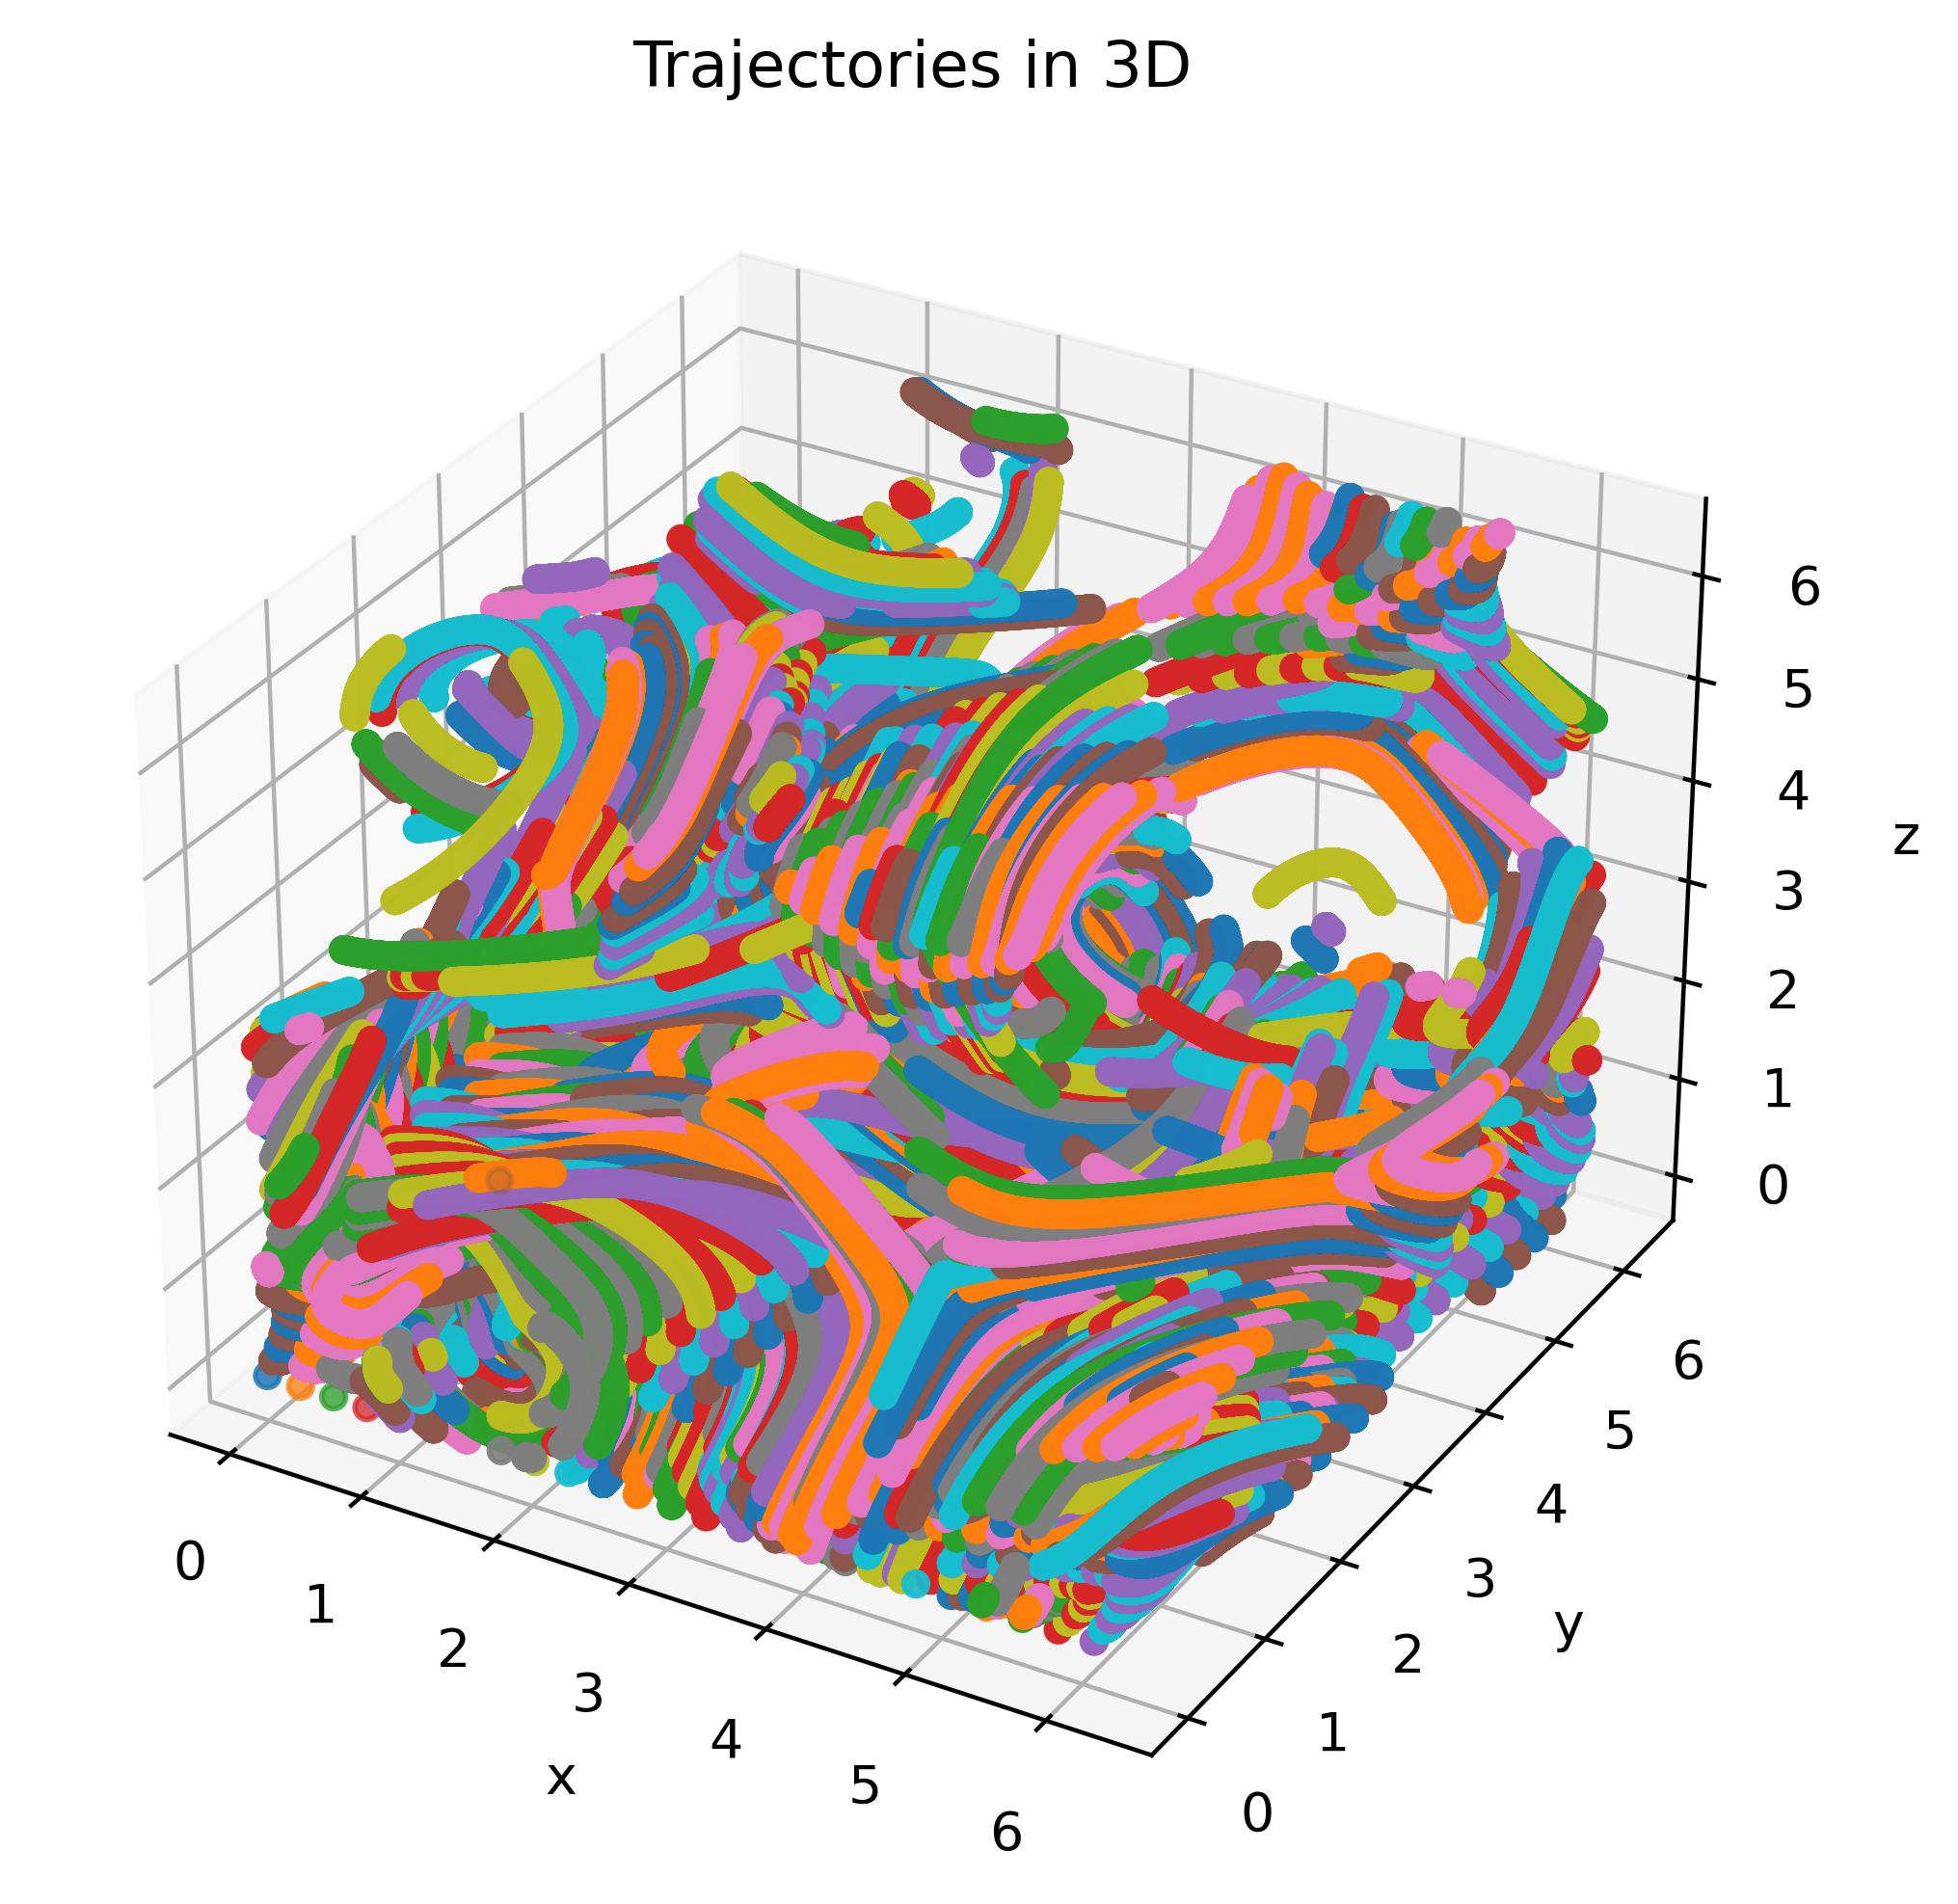

In [23]:
# plot intersection of trajectories with plane z=0
fig = plt.figure(figsize = (10, 6), dpi = 400)
ax = plt.axes(projection = '3d')
for sol in solODE:
    x = sol.y[0,:]%(2*pi)
    y = sol.y[1,:]%(2*pi)
    z = sol.y[2,:]%(2*pi)
    phi = sol.y[3,:]%(2*pi)
    theta = sol.y[4,:]%(pi)
    ax.scatter(x, y, z)
    
ax.set_title("Trajectories in 3D")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()